In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os import path
import os 

from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
6.564200356000015
GPU (s):
0.1082240499999898
GPU speedup over CPU: 60x


In [ ]:
batch = 32
img_shape = (150,150,3)
train = False

# Create dataset

In [ ]:
train_dir = '/content/drive/MyDrive/Data/train'
valid_dir = '/content/drive/MyDrive/Data/validation'
test_dir = '/content/drive/MyDrive/Data/test'

In [ ]:
def create_ds(path):
  return tf.keras.utils.image_dataset_from_directory(path,labels='inferred',label_mode='categorical',image_size=(150,150),batch_size=batch)

In [ ]:
train_ds = create_ds(train_dir)
valid_ds = create_ds(valid_dir)
test_ds = create_ds(test_dir)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Model

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=img_shape,pooling='avg')
base_model.trainable = False

In [ ]:

model = Sequential()
#model.add(augmentation)
model.add(base_model)
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(36,activation='softmax'))

if not train:
  model = load_model('/content/drive/MyDrive/model_high_accuracy')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 36)                9252      
                                                                 
Total params: 24,121,508
Trainable params: 24,068,388
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
if train:
  base_model.trainable = False
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  history = model.fit(train_ds, batch_size=batch, epochs=15, validation_data=valid_ds, callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])

In [ ]:
if train:
  def print_accuracy():
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.grid(True)
    plt.legend(['accuracy', 'val_accuracy'])
    plt.xlabel('Epochs')
    plt.show()
  
  def print_loss():
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(['loss', 'val_loss'])
    plt.grid()
    plt.xlabel('Epochs')
  
  print_accuracy()
  print_loss()
  model.evaluate(test_ds, verbose=1)

In [ ]:
if train: 
  base_model.trainable = True 
  model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  history = model.fit(train_ds, batch_size=batch, epochs=10, validation_data=valid_ds, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
  model.save('saved_model/model_res50')
  print_accuracy()
  print_loss()


In [ ]:
model.evaluate(test_ds, verbose=1)

12/12 [==============================] - 12s 244ms/step - loss: 0.0295 - accuracy: 0.9916


[0.029513148590922356, 0.9916434288024902]

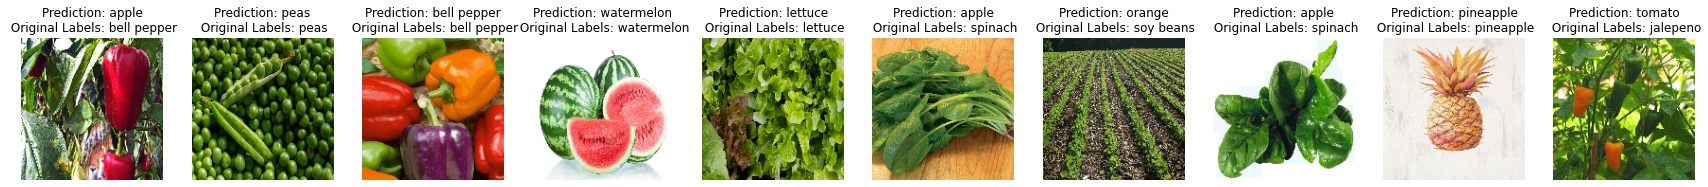

In [ ]:
test_labels = test_ds.class_names

plt.figure(figsize=(30,25))

for image, label in train_ds.take(1):
    model_prediction = model.predict(image)
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(image[i].numpy().astype('int'))
        plt.title(f"Prediction: {test_labels[tf.argmax(tf.round(model_prediction[i]))]}\n Original Labels: {test_labels[tf.argmax(label[i])]}")
        plt.grid(True)
        plt.axis('off')
        
    plt.show()